## preparing data and module

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

## Checking data and preparing functions to be used

In [2]:
def relu(x):
    return np.maximum(x, 0)

In [3]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x)
  return np.exp(x) / np.sum(np.exp(x))

In [4]:
def cross_entropy_error(y, t):
  if y.shape != t.shape:
    raise ValueError
  if y.ndim == 1:
    return - (t * np.log(y)).sum()
  elif y.ndim == 2:
    return - (t * np.log(y)).sum() / y.shape[0]
  else:
    raise ValueError

In [5]:
def forward(x, W1, W2, b1, b2):
    return softmax(np.dot(relu(np.dot(x, W1) + b1), W2) + b2)

In [6]:
def validate_with_test_data(X, y, W1, W2, b1, b2, title=''):
  print(f'{title}{(forward(X, W1, W2, b1, b2).argmax(axis=1) == y.argmax(axis=1)).sum()}/{150 - TRAIN_DATA_SIZE}')

## Checking data

In [7]:
iris = load_iris()

In [8]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [9]:
print(f'names={iris.target_names}')

names=['setosa' 'versicolor' 'virginica']


In [10]:
print(f'shape={iris.data.shape}')

shape=(150, 4)


In [11]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


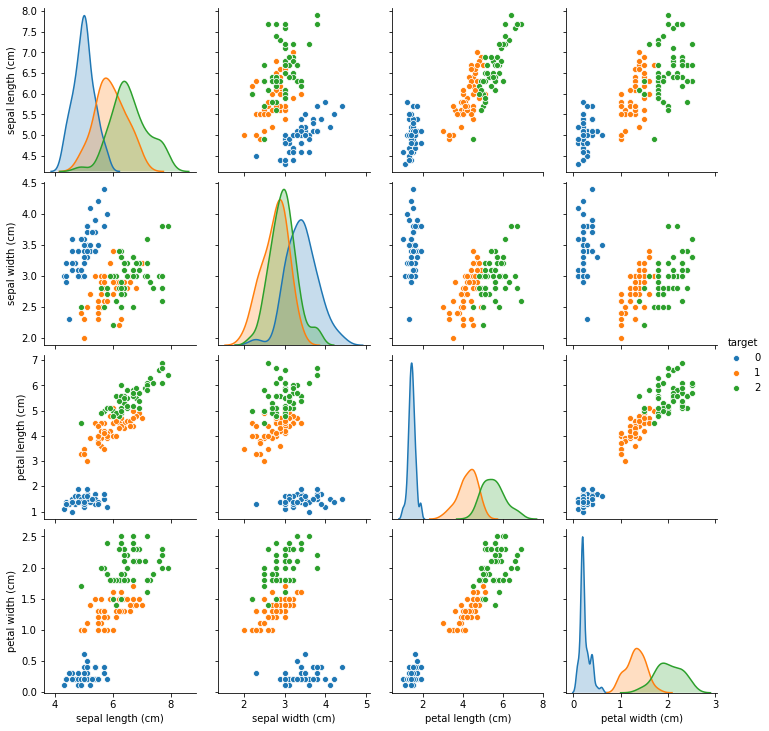

In [12]:
sns.pairplot(df, hue="target")

## Split the data.

In [13]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target.reshape(len(iris.target), 1)
y_one_hot = OneHotEncoder(sparse=False).fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=1, stratify=y_one_hot)

In [14]:
X_test.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
7,5.0,3.4,1.5,0.2
109,7.2,3.6,6.1,2.5
98,5.1,2.5,3.0,1.1
111,6.4,2.7,5.3,1.9
143,6.8,3.2,5.9,2.3


In [15]:
y_test[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

## Building a neural network

In [16]:
INPUT_SIZE = 4
HIDDEN_SIZE = 8
OUTPUT_SIZE = 3
LEARNING_RATE = 0.1
TRAIN_DATA_SIZE = 120
EPOCH = 1001

In [17]:
W1 = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) / np.sqrt(INPUT_SIZE) * np.sqrt(2)  
W2 = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE)/ np.sqrt(HIDDEN_SIZE) * np.sqrt(2)
b1 = np.zeros(HIDDEN_SIZE) 
b2 = np.zeros(OUTPUT_SIZE)

In [18]:
validate_with_test_data(X_test, y_test, W1, W2, b1, b2, "Previous Learning : ")

Previous Learning : 10/30


In [19]:
for i in range(EPOCH):
    # Forward Propagation with Data Storage
    y1 = np.dot(X_train, W1) + b1
    y2 = relu(y1)
    train_y = softmax(np.dot(y2, W2) + b2)

    # Loss function calculation
    L = cross_entropy_error(train_y, y_train)

    # The loss is shown every 100 times.
    if i % 100 == 0:
      validate_with_test_data(X_test, y_test, W1, W2, b1, b2, f"{i}th time : ")
      print(f'Loss : {L}')

    # Slope calculation
    a1 = (train_y - y_train) / TRAIN_DATA_SIZE
    b2_gradient = a1.sum(axis=0)
    W2_gradient = np.dot(y2.T, a1)
    a2 = np.dot(a1, W2.T)
    a2[y1 <= 0.0] = 0
    b1_gradient = a2.sum(axis=0)
    W1_gradient = np.dot(X_train.T, a2)

    # Update parameters
    W1 = W1 - LEARNING_RATE * W1_gradient
    W2 = W2 - LEARNING_RATE * W2_gradient
    b1 = b1 - LEARNING_RATE * b1_gradient
    b2 = b2 - LEARNING_RATE * b2_gradient

0th time : 10/30
Loss : 3.670254393487529
100th time : 25/30
Loss : 0.32884822634051114
200th time : 30/30
Loss : 0.23671587038150818
300th time : 30/30
Loss : 0.16185501097222296
400th time : 30/30
Loss : 0.13512303370646908
500th time : 30/30
Loss : 0.11637827218126823
600th time : 30/30
Loss : 0.10676239227122082
700th time : 30/30
Loss : 0.09959917232482286
800th time : 30/30
Loss : 0.09550748535840696
900th time : 30/30
Loss : 0.0913751367244493
1000th time : 30/30
Loss : 0.0884907784731897


In [20]:
L = cross_entropy_error(forward(X_train, W1, W2, b1, b2), y_train)
print(f'Loss : {L}')

validate_with_test_data(X_test, y_test, W1, W2, b1, b2, f"Last : ")

Loss : 0.09205039482727378
Last : 30/30
